### Build local cache file from Argo data sources - first in a series of Notebooks
*Execute commands to pull data from the Internet into a local HDF cache file so that we can better interact with the data*

If this Notebook is running on a development system (where `pip install biofloat` has not been executed) &mdash; oxyfloat's parent directory needs to be added to the Python search path. 

In [1]:
import sys
sys.path.insert(0, '../')

Import the ArgoData class and instatiate an ArgoData object (`ad`) with verbosity set to 2 so that we get INFO messages.

In [2]:
from biofloat import ArgoData
ad = ArgoData(verbosity=2)

You can now explore what methods the of object has by typing "`ad.`" in a cell and pressing the tab key. One of the methods is `get_oxy_floats()`; to see what it does select it and press shift-tab with the cursor in the parentheses of "`of.get_oxy_floats()`". Let's get a list of all the floats that have been out for at least 340 days and print the length of that list.

In [3]:
%%time
floats340 = ad.get_oxy_floats_from_status(age_gte=340)
print('{} floats at least 340 days old'.format(len(floats340)))

INFO:root:Reading data from http://argo.jcommops.org/FTPRoot/Argo/Status/argo_all.txt
INFO:requests.packages.urllib3.connectionpool:Starting new HTTP connection (1): argo.jcommops.org


564 floats at least 340 days old
CPU times: user 1.15 s, sys: 154 ms, total: 1.3 s
Wall time: 27.1 s


If this the first time you've executed the cell it will take minute or so to read the Argo status information from the Internet (the PerformanceWarning can be ignored - for this small table it doesn't matter much). 

Once the status information is read it is cached locally and further calls to `get_oxy_floats_from_status()` will execute much faster. To demonstrate, let's count all the oxygen labeled floats that have been out for at least 2 years. 

In [4]:
%%time
floats730 = ad.get_oxy_floats_from_status(age_gte=730)
print('{} floats at least 730 days old'.format(len(floats730)))

400 floats at least 730 days old
CPU times: user 97 ms, sys: 11 ms, total: 108 ms
Wall time: 144 ms


Now let's find the Data Assembly Center URL for each of the floats in our list. (The returned dictionary of URLs is also locally cached.)

In [5]:
%%time
dac_urls = ad.get_dac_urls(floats340)
print(len(dac_urls))

INFO:root:Reading data from ftp://ftp.ifremer.fr/ifremer/argo/ar_index_global_meta.txt


563
CPU times: user 905 ms, sys: 11 ms, total: 916 ms
Wall time: 4.59 s


Now, whenever we need to get profile data our lookups for status and Data Assembly Centers will be serviced from the local cache. Let's get a Pandas DataFrame (`df`) of 20 profiles from the float with WMO number 1900650.

In [6]:
%%time
wmo_list = ['1900650']
ad.set_verbosity(0)
df = ad.get_float_dataframe(wmo_list, max_profiles=20)

CPU times: user 2.82 s, sys: 40 ms, total: 2.86 s
Wall time: 57 s


Profile data is also cached locally. To demonstrate, perform the same command as in the previous cell and note the time difference.

In [7]:
%%time
df = ad.get_float_dataframe(wmo_list, max_profiles=20)

CPU times: user 1.24 s, sys: 9 ms, total: 1.25 s
Wall time: 2.36 s


Examine the first 5 records of the float data.

In [8]:
df.head()

DOXY_ADJUSTED  \
wmo     time                       lon     lat   pressure                  
1900650 2010-03-12 01:39:40.003200 -14.026 6.031 4.3          206.490005   
                                                 5.9          206.380005   
                                                 9.1          206.300003   
                                                 13.9         206.850006   
                                                 19.5         206.860001   

                                                           PSAL_ADJUSTED  \
wmo     time                       lon     lat   pressure                  
1900650 2010-03-12 01:39:40.003200 -14.026 6.031 4.3           34.827457   
                                                 5.9           34.827457   
                                                 9.1           34.827457   
                                                 13.9          34.826454   
                                                 19.5          34.847443   

                                                           TEMP_ADJUSTED  
wmo     time                       lon     lat   pressure                 
1900650 2010-03-12 01:39:40.003200 -14.026 6.031 4.3           29.790001  
                                                 5.9           29.789000  
                                                 9.1           29.790001  
                                                 13.9          29.787001  
                                                 19.5          29.681999

There's a lot that can be done with the profile data in this DataFrame structure. We can construct a `time_range` string and query for all the data values from less than 10 decibars:

In [9]:
time_range = '{} to {}'.format(df.index.get_level_values('time').min(), 
                               df.index.get_level_values('time').max())
df.query('pressure < 10')

DOXY_ADJUSTED  \
wmo     time                          lon     lat   pressure                  
1900650 2010-03-12 01:39:40.003200000 -14.026 6.031 4.3          206.490005   
                                                    5.9          206.380005   
                                                    9.1          206.300003   
        2010-02-20 01:52:38.035200000 -14.866 5.551 4.5          204.110001   
                                                    6.3          204.399994   
                                                    9.2          204.110001   
        2010-02-10 01:57:26.956800000 -14.929 5.492 4.5          190.630005   
                                                    6.2          190.190002   
                                                    9.4          187.940002   
        2010-01-31 01:02:30.019199999 -15.038 5.725 4.4          195.669998   
                                                    6.4          194.520004   
                                                    9.5          192.750000   
        2010-01-21 02:05:11.011200000 -15.077 5.719 4.6          198.949997   
                                                    6.4          198.880005   
                                                    9.2          199.139999   
        2010-01-11 01:07:43.996800000 -15.128 5.117 4.5          199.960007   
                                                    6.2          199.539993   
                                                    9.1          199.520004   
        2010-01-01 01:10:18.998400000 -15.162 5.184 4.4          181.919998   
                                                    6.0          181.240005   
                                                    8.8          179.059998   
        2009-12-22 01:12:05.011200000 -15.207 5.685 4.8          117.779999   
                                                    6.7          133.360001   
                                                    9.5          177.119995   
        2009-12-11 23:35:43.987200000 -15.374 5.600 4.3          165.770004   
                                                    6.1          163.679993   
                                                    9.0          159.630005   
        2009-12-01 23:41:39.004800000 -15.373 6.082 4.5          145.250000   
                                                    6.3          142.309998   
                                                    9.2          138.949997   
        2009-11-22 01:18:26.035200000 -15.311 6.241 4.6          121.760002   
                                                    6.4          119.480003   
                                                    9.3          113.839996   
        2009-11-11 23:15:41.040000000 -15.862 6.140 4.6          129.660004   
                                                    6.4          124.559998   
                                                    9.2          116.660004   
        2009-11-02 02:46:59.980800000 -16.458 5.963 4.0          148.809998   
                                                    6.2          145.509995   
                                                    9.2          140.770004   
        2009-10-23 01:23:59.971200000 -16.597 5.742 4.7           43.430000   
                                                    6.2           44.910000   
                                                    9.0           64.629997   
        2009-10-13 03:00:00.000000000 -16.724 5.618 4.4          161.570007   
                                                    6.3          160.309998   
                                                    9.3          158.979996   
        2009-10-02 23:46:59.980800000 -17.357 5.626 4.6          183.649994   
                                                    6.2          182.570007   
                                                    8.9          181.380005   
        2009-09-23 01:30:00.000000000 -17.463 6.054 4.2          192.330002   
                                 

In one command we can take the mean of all the values from the upper 10 decibars:

In [10]:
df.query('pressure < 10').groupby(level=['wmo', 'time']).mean()

DOXY_ADJUSTED  PSAL_ADJUSTED  \
wmo     time                                                          
1900650 2009-08-24 01:36:59.990400000     196.166667      34.635293   
        2009-09-03 01:39:59.961600000     200.486664      34.633526   
        2009-09-12 23:12:59.990400000     202.010000      35.077201   
        2009-09-23 01:30:00.000000000     191.626668      34.910834   
        2009-10-02 23:46:59.980800000     182.533335      34.813449   
        2009-10-13 03:00:00.000000000     160.286667      34.566499   
        2009-10-23 01:23:59.971200000      50.989999      34.757608   
        2009-11-02 02:46:59.980800000     145.029999      34.667896   
        2009-11-11 23:15:41.040000000     123.626668      34.569499   
        2009-11-22 01:18:26.035200000     118.360001      34.545078   
        2009-12-01 23:41:39.004800000     142.169998      34.523666   
        2009-12-11 23:35:43.987200000     163.026667      34.810046   
        2009-12-22 01:12:05.011200000     142.753332      33.912081   
        2010-01-01 01:10:18.998400000     180.740000      34.332881   
        2010-01-11 01:07:43.996800000     199.673335      34.392058   
        2010-01-21 02:05:11.011200000     198.990000      35.032192   
        2010-01-31 01:02:30.019199999     194.313334      34.679620   
        2010-02-10 01:57:26.956800000     189.586670      34.772458   
        2010-02-20 01:52:38.035200000     204.206665      35.151833   
        2010-03-12 01:39:40.003200000     206.390004      34.827457   

                                       TEMP_ADJUSTED  
wmo     time                                          
1900650 2009-08-24 01:36:59.990400000      27.175667  
        2009-09-03 01:39:59.961600000      27.277000  
        2009-09-12 23:12:59.990400000      27.115334  
        2009-09-23 01:30:00.000000000      27.465333  
        2009-10-02 23:46:59.980800000      27.766000  
        2009-10-13 03:00:00.000000000      28.086333  
        2009-10-23 01:23:59.971200000      28.383000  
        2009-11-02 02:46:59.980800000      28.403667  
        2009-11-11 23:15:41.040000000      28.786667  
        2009-11-22 01:18:26.035200000      29.077667  
        2009-12-01 23:41:39.004800000      28.471667  
        2009-12-11 23:35:43.987200000      28.672667  
        2009-12-22 01:12:05.011200000      29.030333  
        2010-01-01 01:10:18.998400000      28.845667  
        2010-01-11 01:07:43.996800000      29.048000  
        2010-01-21 02:05:11.011200000      29.036000  
        2010-01-31 01:02:30.019199999      29.146333  
        2010-02-10 01:57:26.956800000      29.654667  
        2010-02-20 01:52:38.035200000      29.461000  
        2010-03-12 01:39:40.003200000      29.789667

We can plot the profiles:

Populating the interactive namespace from numpy and matplotlib


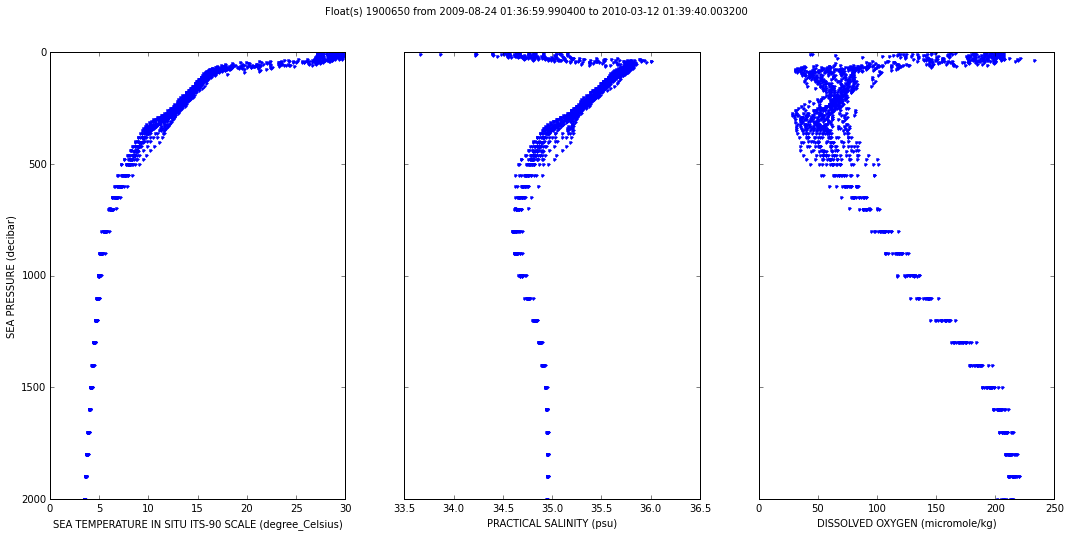

In [11]:
%pylab inline
import pylab as plt
# Parameter long_name and units copied from attributes in NetCDF files
parms = {'TEMP_ADJUSTED': 'SEA TEMPERATURE IN SITU ITS-90 SCALE (degree_Celsius)', 
         'PSAL_ADJUSTED': 'PRACTICAL SALINITY (psu)',
         'DOXY_ADJUSTED': 'DISSOLVED OXYGEN (micromole/kg)'}

plt.rcParams['figure.figsize'] = (18.0, 8.0)
fig, ax = plt.subplots(1, len(parms), sharey=True)
ax[0].invert_yaxis()
ax[0].set_ylabel('SEA PRESSURE (decibar)')

for i, (p, label) in enumerate(parms.iteritems()):
    ax[i].set_xlabel(label)
    ax[i].plot(df[p], df.index.get_level_values('pressure'), '.')
    
plt.suptitle('Float(s) ' + ' '.join(wmo_list) + ' from ' + time_range)

We can plot the location of these profiles on a map:

/home/mccann/VirtualEnvs/oxyfloat/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


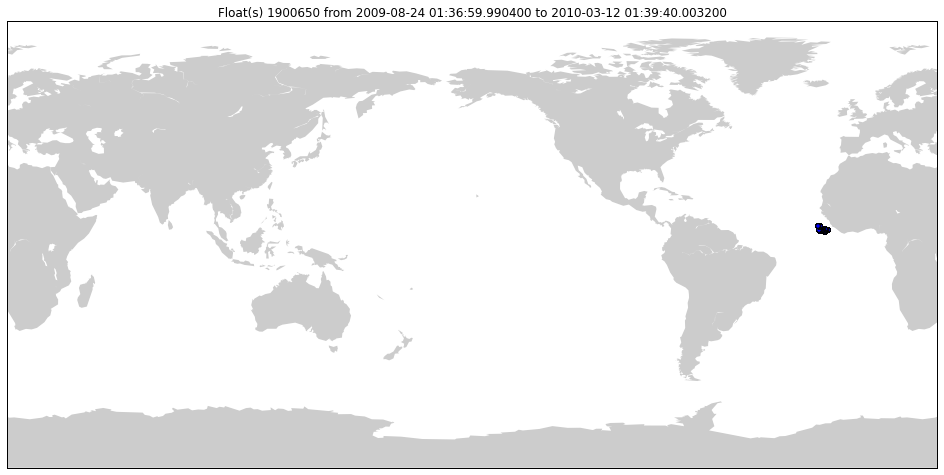

In [12]:
from mpl_toolkits.basemap import Basemap

m = Basemap(llcrnrlon=15, llcrnrlat=-90, urcrnrlon=390, urcrnrlat=90, projection='cyl')
m.fillcontinents(color='0.8')

m.scatter(df.index.get_level_values('lon'), df.index.get_level_values('lat'), latlon=True)
plt.title('Float(s) ' + ' '.join(wmo_list) + ' from ' + time_range)